In [1]:
# PYTHON IMPORTS
import os
import copy
from tqdm.notebook import trange, tqdm

# IMAGE IMPORTS 
from PIL import Image
import cv2

# DATA IMPORTS 
import random
import h5py
import numpy as np
import glob

# PLOTTING
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# NEURAL NETWORK
import torch

# MY OWN CLASSES
from TileLocator import *
from SquareLocator import * 
Image.MAX_IMAGE_PIXELS = 933120000

In [2]:
data_dir = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data/"

In [9]:
def identifyBiggestContour(image, initial_image=None):
        
    if initial_image is None:
        initial_image = image
          
    if initial_image.ndim == 3:
        initial_image = initial_image[:, :, 0]

    # PREPROCESS IMAGE
    sharpened_image = np.where(image > 150, 255, 0).astype(np.uint8)
    edges = cv2.Canny(sharpened_image, 1, 1)
    edges = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=1)
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # LOOP THROUGH IDENTIFIED CONTOURS, SIMPLIFY, AND FILTER BY NUMBER / AREA
    area_ratios = list()
    if image.ndim == 2:
        image_size = image.size
    else:
        image_size = image[:, :, 0].size

    for contour in contours:
        area_ratio = cv2.contourArea(contour) / image_size
        area_ratios.append(area_ratio)

    idx = np.argmax(np.array(area_ratios))
    rectangles_image = np.dstack((initial_image.copy(), initial_image.copy(), initial_image.copy()))
    cv2.drawContours(rectangles_image, contours, -1, (0, 0, 255), 10)
    cv2.drawContours(rectangles_image, [contours[idx]], -1, (0, 255, 0), 10)
    
    epsilon = 0.1 * cv2.arcLength(contours[idx], True)
    approx = cv2.approxPolyDP(contours[idx], epsilon, True)
    cv2.drawContours(rectangles_image, [approx], -1, (255, 0 , 0), 10)
    
    
    return rectangles_image, contours[idx], approx

def findSquares(image, model=None, model_checkpoint=f"{data_dir}SquareLocator/checkpoint_072923.pth"):
    
    # Initialize model
    if model is None:
        model = SquareLocator(finalpadding=1)
        model.load_state_dict(torch.load(model_checkpoint)['model_state_dict'])
    model = model.to("cuda")

    tensor = transforms.Compose([transforms.ToTensor()])

    # INPUT IMAGE AND PREP
    shape = image.shape
    image = cv2.resize(image, (512, 512))   
    image_prep = tensor(image).unsqueeze(0).to("cuda")

    # PROCESS IMAGE
    outputs = model(image_prep)
    outputs = outputs[0, :, :, :].detach().cpu().numpy()
    
    # POSTPROCESS
    outputs = outputs * 255
    outputs = outputs.astype(np.uint8)
    outputs = cv2.resize(outputs, shape)   
    
    model = model.to("cpu")
    torch.cuda.empty_cache()
    
    return outputs, model

def findKeypoints(image, model=None, model_checkpoint=f"{data_dir}TileLocator/checkpoint_080323.pth"):
    
    # Input handling
    if isinstance(image, np.ndarray):
        image = [image] # Make iterable if needed
    
    # Initialize model if needed
    if model is None:
        model = RectangleClass(num_classes=3)
        model.load_state_dict(torch.load(model_checkpoint)['model_state_dict'])
    model = model.to("cuda")
    
    # PROCESS IMAGE
    for im in image:
        outputs = split_and_run_cnn(Image.fromarray(im), model, tilesize=1024, edges=0, dims_rep=[0])
    
    background, grid, roads = outputs[:, :, 0], outputs[:, :, 1], outputs[:, :, 2]
    
    model = model.to("cpu")
    torch.cuda.empty_cache()
    
    return (background.T, grid.T, roads.T), model

In [10]:
prep_folder   = f"{data_dir}TileLocator/in_prepped_v2/"    
output_folder = f"{data_dir}TileLocator/out_v2/"

In [11]:
# Load the image
image_path = f'{data_dir}TileLocator/in_prepped_v2/48071CIND0A.tif'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

classifications, classModel = findKeypoints(image)
effectiveArea, effectiveAreaModel = findSquares(image)

  0%|          | 0/15 [00:00<?, ?it/s]

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 76308480000 bytes in function 'cv::OutOfMemoryError'


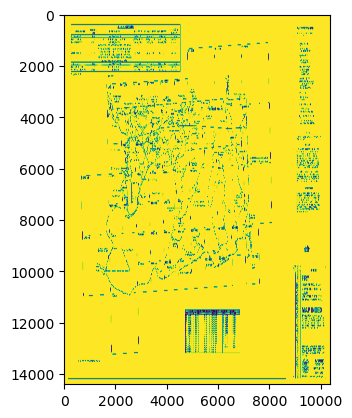

In [8]:
plt.imshow(effectiveArea)

In [8]:
image_path = f'{data_dir}TileLocator/in_prepped_v2/48071CIND0A.tif'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (512, 512)) 

a, b, c = identifyBiggestContour(outputs)
image_mask = cv2.drawContours(a[:, :, 0] * 0, contours=[c],contourIdx=-1, 
                              color=(255), thickness=cv2.FILLED)

In [9]:
# Define the target dimensions for processing
target_dim = (1200, 1200)

# Process the image and get the result
def upscale_to_max(image, target_dim, threshold=50):
    resized_image = cv2.resize(image, target_dim, interpolation=cv2.INTER_LINEAR)
    resized_image[resized_image > threshold] = 255  # Set pixel values above threshold to max (255)
    return resized_image

# Rescale the image to the target dimensions
resized_image = cv2.resize(image, target_dim, interpolation=cv2.INTER_AREA)

# Convert the resized image to grayscale
threshold = 10
gray = np.logical_or(resized_image[:, :, 0] > threshold, resized_image[:, :, 1] > threshold) * 255
gray = gray.astype(np.uint8)


# Apply Hough Transform to detect lines
lines = cv2.HoughLinesP(gray, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=35)
print(lines)

# Draw the detected lines on a copy of the resized image
image_with_lines = resized_image.copy() * 0
for line in lines:
    x1, y1, x2, y2 = line[0]
    
    colors = np.random.randint(255, size=3).astype(np.int32)
    color = ( int (colors [ 0 ]), int (colors [ 1 ]), int (colors [ 2 ])) 
    cv2.line(image_with_lines, (x1, y1), (x2, y2), color, 2)

# Rescale the image with detected lines back to the original dimensions
result_image = cv2.resize(image_with_lines, image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
cv2.imwrite("test.png", result_image)
cv2.imwrite("test1.png", image)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [10]:
def extend_lines_to_edges(lines, image_shape):
    extended_lines = []

    for line in tqdm(lines):
        x1, y1, x2, y2 = line[0]

        # Calculate the line's slope
        dx = x2 - x1
        dy = y2 - y1
        slope = dy / dx if dx != 0 else np.inf

        # Extend line origin to the image edges
        if slope != np.inf:
            extended_x1 = 0
            extended_y1 = int(y1 - (x1 - extended_x1) * slope)
        else:
            extended_x1 = x1
            extended_y1 = 0

        extended_lines.append((extended_x1, extended_y1, x2, y2))

    return extended_lines

image_height, image_width, _ = resized_image.shape
# Example list of lines (x1, y1, x2, y2) format

# Extend the lines to the edges of the image
extended_lines = extend_lines_to_edges(lines, (image_width, image_height))

# Draw the original lines on the image (for visualization)
image_with_lines = resized_image.copy() * 0
for line in tqdm(lines):
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Draw the extended lines on the image
image_with_extended_lines = resized_image.copy() * 0
for line in tqdm(extended_lines):
    x1, y1, x2, y2 = line
    cv2.line(image_with_extended_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the original image with lines and the image with extended lines
cv2.imwrite('test.png', image_with_lines)
cv2.imwrite('test1.png', image_with_extended_lines)


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

True

(0.0, 1200.0)

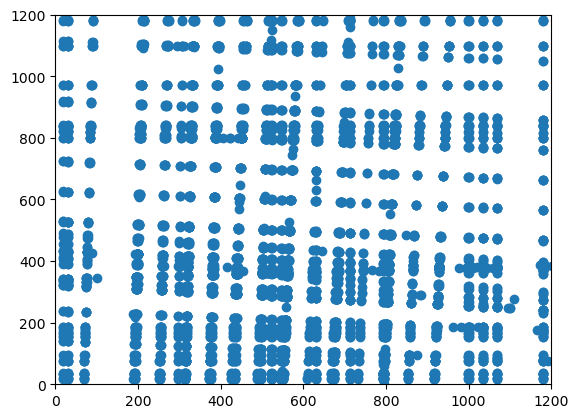

In [92]:
def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    if denominator == 0:
        return None  # Lines are parallel or coincident

    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

    return px, py

def find_all_intersections(lines):
    intersections = []
    num_lines = len(lines)

    for i in range(num_lines - 1):
        for j in range(i + 1, num_lines):
            intersection = line_intersection(lines[i][0], lines[j][0])
            if intersection:
                intersections.append([intersection[0], intersection[1]])

    return intersections

intersections = find_all_intersections(lines)
intersections = np.array(intersections)

plt.scatter(intersections[:, 0], intersections[:, 1])
plt.xlim((0, 1200))
plt.ylim((0, 1200))